<a href="https://colab.research.google.com/github/spe301/Clustering-Automobile-Customers/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install Potosnail==0.0.9

In [31]:
from potosnail import *
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

ml = MachineLearning()
dh = DataHelper()
ev = Evaluater()
st = Stats()

def GetTopN(df, var, n):
    dict(df[var].value_counts())
    X = list({v: k for k, v in dict(df[var].value_counts()).items()}.values())[:n]
    y = list({v: k for k, v in dict(df[var].value_counts()).items()}.keys())[:n]
    sns.barplot(X, y);
    plt.show()

def BinaryBarGraph(df, opt1, opt2, var):
    yes = len(df.loc[df[var] == opt1])/len(df)
    no = 1 - yes
    X = [opt1, opt2]
    y = [yes, no]
    sns.barplot(X, y);
    plt.show()
    return 'The sample is {}% {} and {}% {}'.format(int(round(yes*100)), opt1, int(round(no*100)), opt2)

def ClusterIt(data, clusters):
    k = KMeans(n_clusters=clusters).fit(data)
    pred = k.predict(data)
    centers = k.cluster_centers_
    X2 = pd.DataFrame(data)
    y = pd.DataFrame(pred)
    y.columns = ['cluster']
    results = pd.concat([X2, y], axis='columns')
    return results

In [32]:
d1 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Train.csv')
d2 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Test.csv')
df = pd.concat([d1, d2]).drop(['ID', 'Var_1', 'Segmentation'], axis='columns').reset_index()

# How I'm going to go about this...

Scrub: clean this data so it can be interpreted by a model

Explore: draw insights and visualize the data

Model: build a Clustering model to segment the customers into 5 distinct segments, one for each product

Interpret: analyze the clusters to match each cluster with the appropriate product.

# Scrub
## Filling in NaN values

In [33]:
df['Ever_Married'] = df['Ever_Married'].fillna('No')
df['Graduated'] = df['Graduated'].fillna('No')
df['Profession'] = df['Profession'].fillna('None')
df['Work_Experience'] = df['Work_Experience'].fillna(int(np.mean(df['Work_Experience'])))
df['Family_Size'] = df['Family_Size'].fillna(int(round(np.mean(df['Family_Size']))))
df.isna().sum()

index              0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
dtype: int64

In [34]:
#df = df.drop(['index'], axis='columns')
df.head()

,index,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,1,Female,Yes,38,Yes,Engineer,2.0,Average,3.0
2,2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,4,Female,Yes,40,Yes,Entertainment,2.0,High,6.0


Converting gender, married, and graduated to 0's and 1's. However, I will also keep the original columns for Analysis purposes.

In [ ]:
lst = ['Gender', 'Ever_Married', 'Graduated']
keepers = df[lst]

In [ ]:
df2 = pd.concat([dh.Binarize(df, lst), keepers], axis='columns')
df2.columns = list(df2.columns)[:-3] + ['Gender_str', 'Married_str', 'Grad_str']
df2.head()

,index,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str
0,0,1,1,22,1,Healthcare,1.0,Low,4.0,Male,No,No
1,1,0,0,38,0,Engineer,2.0,Average,3.0,Female,Yes,Yes
2,2,0,0,67,0,Engineer,1.0,Low,1.0,Female,Yes,Yes
3,3,1,0,67,0,Lawyer,0.0,High,2.0,Male,Yes,Yes
4,4,0,0,40,0,Entertainment,2.0,High,6.0,Female,Yes,Yes


One Hot Encoding Profession, again I will hold onto the original column for Analysis purposes.

In [ ]:
df3 = pd.concat([df2, dh.OHE(df2['Profession'])], axis='columns')
df3.head()

,index,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,0,1,1,22,1,Healthcare,1.0,Low,4.0,Male,No,No,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,0,38,0,Engineer,2.0,Average,3.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,67,0,Engineer,1.0,Low,1.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,67,0,Lawyer,0.0,High,2.0,Male,Yes,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0,0,40,0,Entertainment,2.0,High,6.0,Female,Yes,Yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Converting Spending Score to numerical data, this time I will drop the original column altogether bceause the data is rankable. (ie. 1 can represent low, 2 average, and so on)

In [ ]:
ss = df3['Spending_Score']
scores = []
for i in range(len(ss)):
    if ss[i] == 'Low':
        scores.append(1)
    if ss[i] == 'Average':
        scores.append(2)
    if ss[i] == 'High':
        scores.append(3)
        
df3['Spending_Score'] = scores

In [ ]:
df3.head()

,index,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_str,Married_str,Grad_str,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,0,1,1,22,1,Healthcare,1.0,1,4.0,Male,No,No,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,0,0,38,0,Engineer,2.0,2,3.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,67,0,Engineer,1.0,1,1.0,Female,Yes,Yes,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,0,67,0,Lawyer,0.0,3,2.0,Male,Yes,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,0,0,40,0,Entertainment,2.0,3,6.0,Female,Yes,Yes,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA questions

1. How is age distributed among different Spending Scores?
2. is the difference in spending score for married and unmarried customers statistically signifigant?
3. What are the most common professions among each spending score and how do they differ?

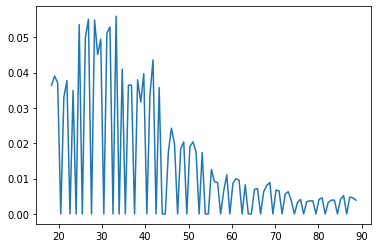

In [ ]:
st.PDF(df3.loc[df3['Spending_Score'] == 1]['Age'])

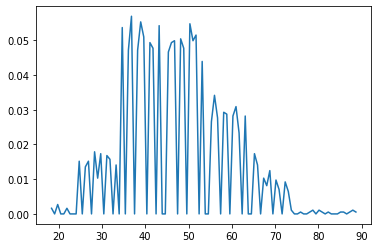

In [ ]:
st.PDF(df3.loc[df3['Spending_Score'] == 2]['Age'])

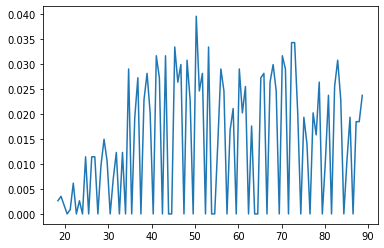

In [ ]:
st.PDF(df3.loc[df3['Spending_Score'] == 3]['Age'])

Conclusion: Spending Scores tend to increase as age increases. Almost all customers with 'low' spending scores are under 50, and the distribution really dips off after 40.

Reccomendation: Avoid marketing more expensive vehicles to people under 35-40.

In [ ]:
n = 100
married_sample = df3.loc[df3['Married_str']=='Yes'].sample(n)['Spending_Score']
unmarried_sample = df3.loc[df3['Married_str']=='No'].sample(n)['Spending_Score']

In [ ]:
married_sample

1713     2
2127     2
1637     1
2382     1
6501     2
        ..
10126    3
1248     2
8699     3
3157     1
1830     3
Name: Spending_Score, Length: 100, dtype: int64

In [ ]:
stats.ttest_ind(unmarried_sample, married_sample)

Ttest_indResult(statistic=-12.267492788273602, pvalue=4.221135549399124e-26)

H0 = there's no correlation between spending and being married

H1 = married people tend to spend less because they often have to agree on the purchase with their spouse.

We reject the null hypothesis, however it actually turns out that unmarried customers have lower spending scores on average. most likley because only one person will pay for the car.

Reccomendation: Prioritize advertising towards married people in general as they're likley to spend more.

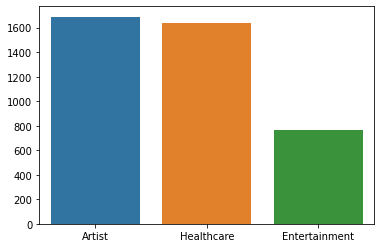

None
Where Spending Score = 1


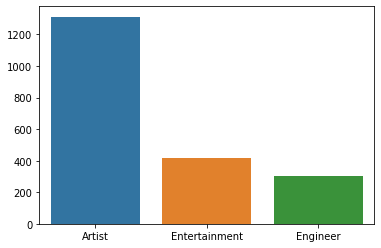

None
Where Spending Score = 2


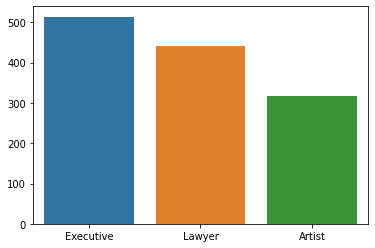

None
Where Spending Score = 3

31% of the customers in this dataset are artists


In [ ]:
for i in range(1, 4):
  data = df3.loc[df3['Spending_Score']==i]
  print(GetTopN(data, 'Profession', 3))
  print('Where Spending Score = {}'.format(i))

print()
print('{}% of the customers in this dataset are artists'.format(round(len(df3.loc[df['Profession']=='Artist'])/len(df3)*100)))

Conclusion: Healthcare workers tend to spend the least, while lawers and executives tend to spend the most.

Reccomendation: Even without any clustering, we can infer that it's best that our Sedan be marketed to healthcare workers while the sport's car should be catered to execs and lawers. These findings also suggest that the pickup truck may not do well, but there is no evidence.

# Modeling

I use K-Means Clustering to categorize our customers into 5 distinct groups, one for each product. I will then use PCA to reduce the data to 2 dimensions so we can acually visualize it, but keep in mind that this second model won't be very effective for classification and will only be used for visualization.

In [ ]:
df4 = df3.drop(['Profession', 'Gender_str', 'Married_str', 'Grad_str'], axis='columns') #dropping string (text) values, they have already been converted.

data = dh.ScaleData('standard', df4)

def ClusterIt(data, clusters):
    k = KMeans(n_clusters=clusters).fit(data)
    pred = k.predict(data)
    centers = k.cluster_centers_
    X2 = pd.DataFrame(data)
    y = pd.DataFrame(pred)
    y.columns = ['cluster']
    results = pd.concat([X2, y], axis='columns')
    return results

clustered = ClusterIt(data, 5)['cluster']
##adding string values back in for analysis
df4['Profession'] = df3['Profession']
df4['Gender_str'] = df3['Gender_str']
df4['Married'] = df3['Married_str']
df4['cluster'] = clustered
df4.head()

,index,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None,Profession,Gender_str,Married,cluster
0,0,1,1,22,1,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Healthcare,Male,No,1
1,1,0,0,38,0,2.0,2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Engineer,Female,Yes,0
2,2,0,0,67,0,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Engineer,Female,Yes,0
3,3,1,0,67,0,0.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Lawyer,Male,Yes,4
4,4,0,0,40,0,2.0,3,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Entertainment,Female,Yes,2


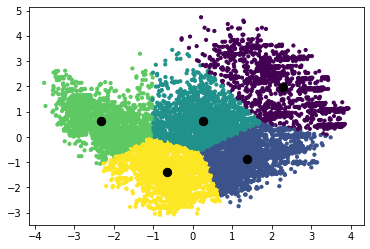

,0,1,cluster
0,-2.848682,1.333361,3
1,0.448767,-0.225816,2
2,1.043105,-0.983784,1
3,3.269105,1.091056,0
4,0.792876,1.081509,2
...,...,...,...
10690,-2.867234,0.880590,3
10691,-0.961627,-1.283494,4
10692,-0.342842,-0.855917,4
10693,1.858137,2.970327,0


In [ ]:
ml.Cluster2D(data, 5)

# Analyzing the clusters

For each cluster I will get the distribution of Age, married to unmarried breakdown, gender breakdown, most common professions, average family size, and average Spending Score.

In [ ]:
c1 = df4.loc[df4['cluster'] == 0]
c2 = df4.loc[df4['cluster'] == 1]
c3 = df4.loc[df4['cluster'] == 2]
c4 = df4.loc[df4['cluster'] == 3]
c5 = df4.loc[df4['cluster'] == 4]

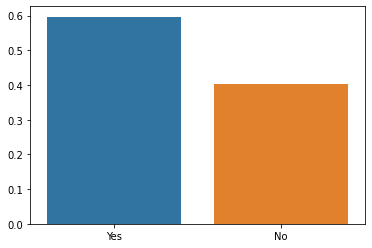

The sample is 60% Yes and 40% No


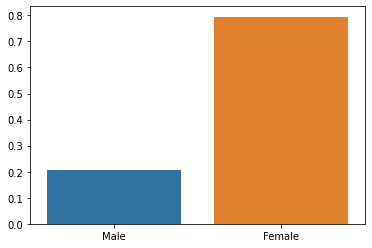

The sample is 21% Male and 79% Female


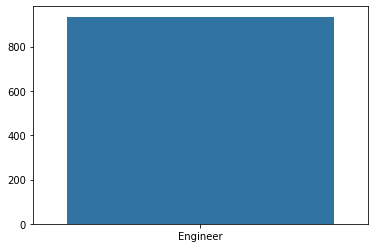

None
The average customer has a family of 2.978609625668449
The average customer has a spending score of 1.483422459893048
None


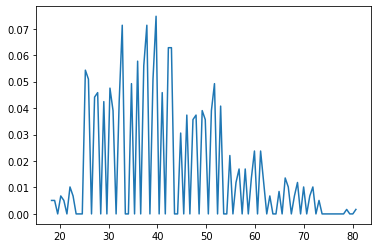

In [ ]:
def BinaryBarGraph(df, opt1, opt2, var):
    yes = len(df.loc[df[var] == opt1])/len(df)
    no = 1 - yes
    X = [opt1, opt2]
    y = [yes, no]
    sns.barplot(X, y);
    plt.show()
    return 'The sample is {}% {} and {}% {}'.format(int(round(yes*100)), opt1, int(round(no*100)), opt2)

def AnalyzeCluster(cluster, var1, var2, var3, var4, var5, var6, opt1, opt2, opt3, opt4, n):
  print(BinaryBarGraph(cluster, opt1, opt2, var2))
  print(BinaryBarGraph(cluster, opt3, opt4, var3))
  print(GetTopN(cluster, var4, n))
  print('The average customer has a family of {}'.format(np.mean(cluster[var5])))
  print('The average customer has a spending score of {}'.format(np.mean(cluster[var6])))

AnalyzeCluster(c1, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c1['Age']))

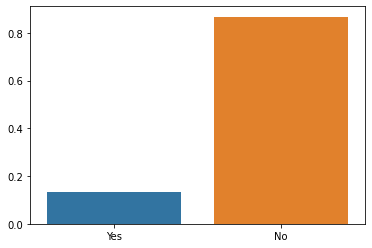

The sample is 13% Yes and 87% No


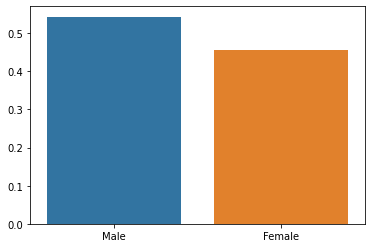

The sample is 54% Male and 46% Female


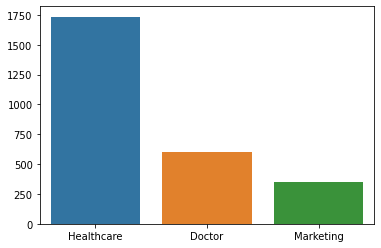

None
The average customer has a family of 3.47609219126247
The average customer has a spending score of 1.0997592019263847
None


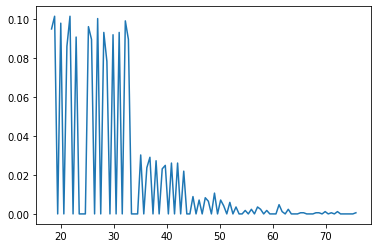

In [ ]:
AnalyzeCluster(c2, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c2['Age']))

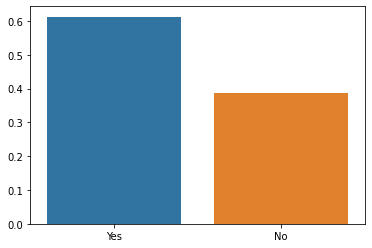

The sample is 61% Yes and 39% No


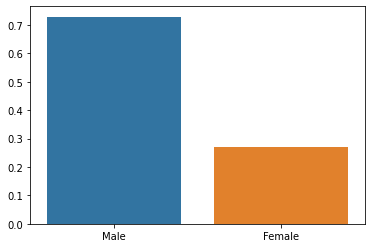

The sample is 73% Male and 27% Female


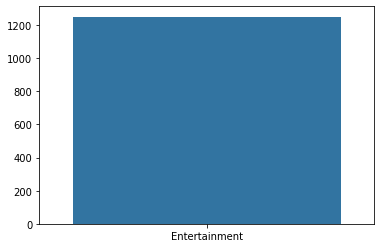

None
The average customer has a family of 2.7816
The average customer has a spending score of 1.4352
None


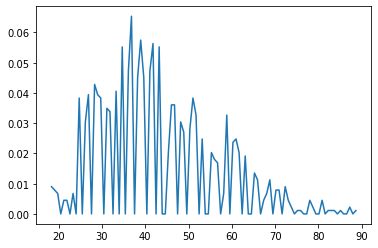

In [ ]:
AnalyzeCluster(c3, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c3['Age']))

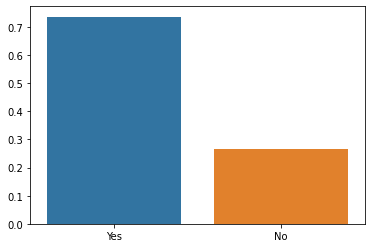

The sample is 74% Yes and 26% No


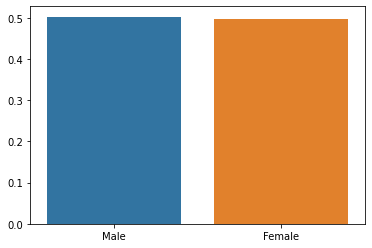

The sample is 50% Male and 50% Female


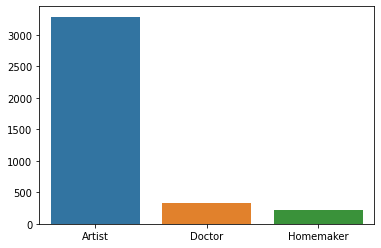

None
The average customer has a family of 2.460365091272818
The average customer has a spending score of 1.6131532883220805
None


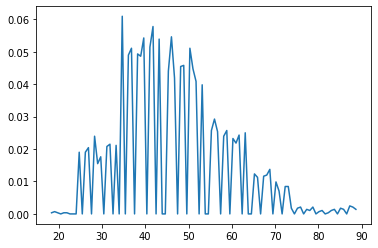

In [ ]:
AnalyzeCluster(c4, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c4['Age']))

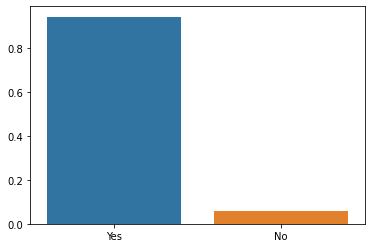

The sample is 94% Yes and 6% No


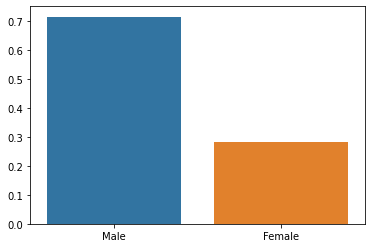

The sample is 72% Male and 28% Female


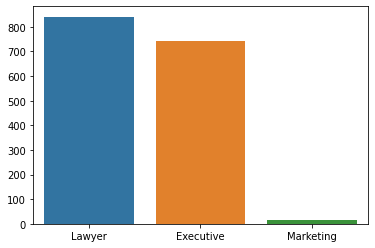

None
The average customer has a family of 2.6689526184538654
The average customer has a spending score of 2.2874064837905235
None


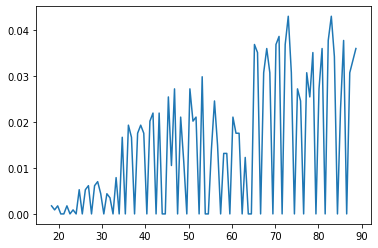

In [ ]:
AnalyzeCluster(c5, 'Age', 'Married', 'Gender_str', 'Profession', 'Family_Size', 'Spending_Score', 'Yes', 'No', 'Male', 'Female', 3)
print(st.PDF(c5['Age']))

Infrences...

Cluster1 = Station Wagon

Cluster2 = Sedan

Cluster3 = Pickup Truck

Cluster4 = Compact SUV

Cluster5 = Sports Car

Additional Reccomendation: The pickup Truck seems the least likley to be a hit but cluster 3 seems the most likley to buy it. if the ads convert poorly, the main focus should shift to advertising the Compact SUV, and we should decrease Truck Production as well.

In [36]:
df4.to_csv('drive/MyDrive/clustered2.csv')